In [38]:
import numpy as np
from scipy.integrate import quad, odeint
from scipy.interpolate import UnivariateSpline
import camb
from camb import model, initialpower
import functools
from scipy.interpolate import CubicSpline
import import_ipynb
from CAMB_MPS import PowerSpectrumCalculator
from scipy.integrate import quad

class vectorize(np.vectorize):
    def __get__(self, obj, objtype):
        return functools.partial(self.__call__, obj)


In [52]:

# Speed of light in km/s
c = 299792.458


class EquationOfState:
    """
    Implements various dark energy equation of state (EoS) parameterizations.
    """
    def __init__(self, w0, wa):
        self.w0 = w0
        self.wa = wa

    def CPL(self, z):
        """Chevallier-Polarski-Linder (CPL) parameterization."""
        return (1 + z) ** (3 * (1 + self.w0 + self.wa)) * np.exp(-3 * self.wa * z / (1 + z))

    def JBP(self, z):
        """Jassal-Bagla-Padmanabhan (JBP) parameterization."""
        return (1 + z) ** (3 * (1 + self.w0)) * np.exp(3 * self.wa * z**2 / (2 * (1 + z)**2))

    def BA(self, z):
        """Barboza-Alcaniz (BA) parameterization."""
        return (1 + z) ** (3 * (1 + self.w0)) * (1 + z**2) ** (3 * self.wa / 2)

    def FSL(self, z):
        """Feng-Shen-Li (FSL) parameterization."""
        fsl1 = (1 + z) ** (3 * (1 + self.w0)) * np.exp(3 * self.wa * np.arctan(z) / 2)
        fsl1 *= (1 + z**2) ** (3 * self.wa / 4) * (1 + z) ** (-3 * self.wa / 2)
        return fsl1


class Background:
    """
    Background cosmology calculations, including Hubble rate and distances.
    """
    def __init__(self, Om, eos_model):
        self.Om = Om
        self.H0 = 67.66  # Default Hubble parameter in km/s/Mpc
        self.eos_model = eos_model

    def Hubble_rate(self, z, method="BA"):
        """Hubble rate as a function of redshift."""
        if method == "CPL":
            dark_energy = self.eos_model.CPL(z)
        elif method == "JBP":
            dark_energy = self.eos_model.JBP(z)
        elif method == "BA":
            dark_energy = self.eos_model.BA(z)
        elif method == "FSL":
            dark_energy = self.eos_model.FSL(z)
        else:
            raise ValueError("Invalid method. Choose from 'CPL', 'JBP', 'BA', or 'FSL'.")
        return self.H0 * np.sqrt(self.Om * (1 + z)**3 + (1 - self.Om) * dark_energy)
    @vectorize
    def Comoving_distance(self, z, method="BA"):
        """
        Compute the comoving distance to a given redshift.

        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".

        Returns:
        float: Comoving distance in units of c/H0.
        """
        DH = 2997.98 * 100 / self.H0 
        integral, _ = quad(lambda z_: self.H0 / self.Hubble_rate(z_, method), 0, z)
        return integral * DH

    def Angular_diameter_distance(self, z, method="BA"):
        """
        Compute the angular diameter distance.
        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".
        Returns:
        float: Angular diameter distance in units of c/H0.
        """
        comoving_distance = self.Comoving_distance(z, method)
        return comoving_distance / (1 + z)

    def Luminosity_distance(self, z, method="BA"):
        """
        Compute the luminosity distance.
        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".
        Returns:
        float: Luminosity distance in units of c/H0.
        """
        comoving_distance = self.Comoving_distance(z, method)
        return comoving_distance * (1 + z)

    @vectorize
    def hubble_normalized_z(self, z, method="BA"):
        '''
        This function returna the normalized Hubble expression
        H(z) = H0*sqrt(Om_m(1+z)^3+Om_DE)
        '''
        return self.Hubble_rate(z, method)/self.H0
    
    def inverse_hubble_normalized_z(self, z, method="BA"):
        '''
        Inverse of the normalized hubble parameter : 1/h(z)
        where  h(z)= H(z)/H0
        '''
        return 1./self.hubble_normalized_z(z, method)
    
    def hubble_normalized_a(self, a, method="BA"):
        '''
        Calculates normalized Hubble parameter h(a)= H(a)/H0
        where H(a) is the Hubble parameter at redshift z and 
        H0 is the current value of Hubble parameter
        '''
        return self.hubble_normalized_z(1./a - 1, method)
    
    def hubble_prime_normalized_a(self, a, method="BA"):
        '''
        Derivative of dimensionless hubble parameter w.r.t a
        '''
        dx = 1e-6
        return (self.hubble_normalized_a(a + dx, method) - self.hubble_normalized_a(a - dx, method)) / (2 * dx)

    def om_0_a(self, a, method="BA"):
        '''
        Omega matter as a function of scale factor
        '''
        return self.Om*a**(-3)/self.hubble_normalized_a(a, method)**2.0
    
    def om_0_z(self, z, method="BA"):
        '''
        Omega matter as a function of redshift
        '''        
        return self.om_0_a(1./(1.+z), method)
 
    a_factor = np.linspace(0.01, 1, 10000)
        
    def deriv(self, y, a, method="BA"):
        #print(f"Method: {method}, a: {a}")

        h_prime = self.hubble_prime_normalized_a(a, method)
        h_norm = self.hubble_normalized_a(a, method)
        omega_m = self.om_0_a(a, method)

        #print(f"H'(a): {h_prime}, H(a): {h_norm}, Omega_m(a): {omega_m}")

        der = [y[1], -(3./a + h_prime / h_norm) * y[1] + 1.5 * omega_m * y[0] / (a**2.)]
        return der
    
    def solution(self, method="BA"):
        '''
        Soution to the matter perturbation 
        Initial condition chosen at early matter dominated area 
        Dm=a=dD/dm at a=0.001
        '''
        y_initial = (0.01,1)
        return odeint(self.deriv, y_initial, self.a_factor, args=(method,), rtol=1e-8, atol=1e-10)
    
    def D_p(self, a, method="BA"):
        '''
        This function does not calculate anything but 
        extracts the solution of the differential equation
        Do not call the function, it does give any output
        '''
        y11 = self.solution(method)[:,0]
        ynn11 = UnivariateSpline(self.a_factor, y11, k=3, s=0)
        return ynn11(a)

    def D_plus_a(self, a, method="BA"):
        '''
        This function return the growing mode solution
        as a function of scale factor i.e D+(a)/D+(a=1) 
        normalized at present epoch
        '''
        return self.D_p(a, method)
    
    @vectorize
    def D_plus_z(self, z, method="BA"):
        '''
        Normalized solution of the growing mode as a function of redshift z
        '''
        return self.D_plus_a(1./(1.+z), method)

    def _initialize_camb_params(self):
        pars = camb.CAMBparams()
        h = (self.H0 / 100)
        ombh2 = 0.045 * h**2  # Assuming baryon fraction is 0.045
        omch2 = (self.Om - 0.045) * h**2
        pars.set_cosmology(H0=self.H0, ombh2=ombh2, omch2=omch2)
        pars.InitPower.set_params(As=2.1e-9, ns=0.96)
        pars.set_matter_power(redshifts=[0], kmax=100.0)
        pars.NonLinear = model.NonLinear_none
        return pars
    
    @vectorize
    def get_matter_power(self, k):
        camb_params = self._initialize_camb_params()
        results = camb.get_results(camb_params)
        kh, _z, pk = results.get_linear_matter_power_spectrum(hubble_units=True,have_power_spectra=True,nonlinear=False)
        spline = CubicSpline(kh, pk[0], bc_type='natural')  # Interpolate P(k)

    # Evaluate the interpolator at the given k
        return spline(k)
    
    @vectorize
    def get_matter_power_z(self, k, z, method="BA"):
        camb_params = self._initialize_camb_params()
        results = camb.get_results(camb_params)
        #kh, _, pk = results.get_matter_power_spectrum(minkh=k * 0.999, maxkh=k * 1.001, npoints=2)
        D_plus_z_value = self.D_plus_z(z, method)  # Accessing D_plus_z from Background
        D_plus_z_0 = self.D_plus_z(0, method)
        kh, _z, pk = results.get_linear_matter_power_spectrum(hubble_units=True,have_power_spectra=True,nonlinear=False)
        spline = CubicSpline(kh, pk[0], bc_type='natural')  # Interpolate P(k)

    # Evaluate the interpolator at the given k
        return spline(k) * (D_plus_z_value/D_plus_z_0)**2
        #return CubicSpline(kh, pk[0], bc_type='natural')#scipy.interpolate.interp1d(kh,pk[0],kind=interp_type#np.mean(pk) * (D_plus_z_value/D_plus_z_0)**2
    @vectorize
    def camb_interpolated_ps_z(self, k, z, method="BA"):
        H0 = self.H0
        Om = self.Om
        calculator = PowerSpectrumCalculator(H0, Om)
        filename = "matter_power_spectrum.txt"
        spline = calculator.load_and_spline_power_spectrum(k, filename)
        #print("Spline interpolator created.")
        D_plus_z_value = self.D_plus_z(z, method)  # Accessing D_plus_z from Background
        D_plus_z_0 = self.D_plus_z(0, method)
        # Evaluate the interpolator at the given k
        return spline * (D_plus_z_value/D_plus_z_0)**2
    @vectorize
    def camb_interpolated_ps(self, k):
        H0 = self.H0
        Om = self.Om
        calculator = PowerSpectrumCalculator(H0, Om)
        filename = "matter_power_spectrum.txt"
        spline = calculator.load_and_spline_power_spectrum(k, filename)
        #print("Spline interpolator created.")
        # Evaluate the interpolator at the given k
        return spline 





In [55]:
eos_lcdm = EquationOfState(w0=-1.0, wa=-0.0)# Lambda-CDM model (w0 = -1, wa = 0)
background_lcdm = Background(Om=0.311, eos_model=eos_lcdm)
k_values = np.logspace(-3, 1, 10)
X = background_lcdm.camb_interpolated_ps(k_values)
X

array([4.16914616e+03, 1.03042081e+04, 2.09508371e+04, 2.49685774e+04,
       1.16667894e+04, 2.68194757e+03, 3.92628009e+02, 3.96792572e+01,
       3.26273753e+00, 2.34855318e-01])

Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.
Spline interpolator created.


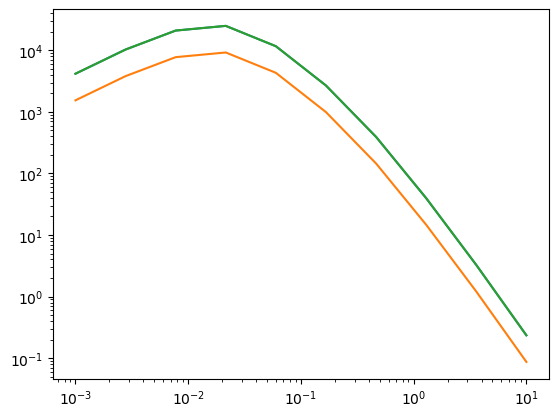

In [57]:
import matplotlib.pyplot as plt
plt.loglog()

plt.plot(k_values, background_lcdm.camb_interpolated_ps_z(k_values, 0, method="BA"))
plt.plot(k_values, background_lcdm.camb_interpolated_ps_z(k_values, 1, method="BA"))
plt.plot(k_values,X)

In [ ]:
# Initialize the equation of state and background
eos_cpl = EquationOfState(w0=-1.1, wa=-0.1)# Lambda-CDM model (w0 = -1, wa = 0)
eos_cpl2 = EquationOfState(w0=-0.9, wa=-0.1)
eos_lcdm = EquationOfState(w0=-1.0, wa=0.0)  # Lambda-CDM model (w0 = -1, wa = 0)

background_lcdm = Background(Om=0.311, eos_model=eos_lcdm)  # Omega_m = 0.3, Lambda-CDM
background_cpl = Background(Om=0.311, eos_model=eos_cpl)  # Omega_m = 0.3, Lambda-CDM
background_cpl2 = Background(Om=0.311, eos_model=eos_cpl2)  # Omega_m = 0.3, Lambda-CDM


# Define a range of k values (in h/Mpc)
#k_values = np.logspace(-3, 1, 10)  # From 10^-3 to 10^1 h/Mpc

# Compute the matter power spectrum for z = 0
#matter_power_spectrum = background.get_matter_power(k_values, 1)
#matter_power_spectrum1 = background_lcdm.get_matter_power_z(k_values, 0, method='BA')
#matter_power_spectrum2 = background_lcdm.get_matter_power_z(k_values, 1, method='BA')
#matter_power_spectrum3 = background_lcdm.get_matter_power_z(k_values, 2, method='BA')


In [ ]:
z = np.linspace(0.1, 2.5, 10)
X = background_lcdm.D_plus_z(z, method='BA')
Y = background_cpl.D_plus_z(z, method ='BA')
Z = background_cpl2.D_plus_z(z, method ='BA')
plt.plot(z, X/X)
plt.plot(z, Y/X, label='-1.1,-0.1')
plt.plot(z, Z/X, label='-0.9,-0.1')
plt.legend()



In [75]:
class PerturbationTheory:
    """
    Perturbation theory for matter 3-point and 4-point functions.
    Incorporates power spectrum from CAMB.
    """
    def __init__(self, eos_model, Background):
        self.eos_model = eos_model
        self.Background = Background

    def alpha_BCGS(self, k1, k2):
        k1sq = np.vdot(k1, k1)
        if k1sq == 0.0:
            return 0.0
        else:
            return np.vdot(k1 + k2, k1) / k1sq

    def gamma_BCGS(self, k1, k2):
        k1a = np.vdot(k1, k1)
        k2a = np.vdot(k2, k2)
        if k1a * k2a == 0.0:
            return 0.0
        else:
            return 1 - (np.vdot(k1, k2)) ** 2 / (k1a * k2a)

    def Fs2(self, k1, k2):
        d = np.dot(k1, k2)
        k1a = np.sqrt(np.dot(k1, k1))
        k2a = np.sqrt(np.dot(k2, k2))
        if k1a < 1.e-8 or k2a < 1.e-8:
            return 5.0 / 7.0
        else:
            rat = d / (k1a * k2a)
            return (5.0 / 7.0 + (rat / 2.0) * (k1a / k2a + k2a / k1a) + (2.0 / 7.0) * rat ** 2)

    def Fs3(self, k1, k2, k3):
        k1a = np.vdot(k1, k1)
        k2a = np.vdot(k2, k2)
        k3a = np.vdot(k3, k3)
        k12a = np.vdot(k1 + k2, k1 + k2)
        k23a = np.vdot(k2 + k3, k2 + k3)
        k123a = np.vdot(k1 + k2 + k3, k1 + k2 + k3)

        b1 = ((1.0 / 21.0) * np.vdot(k1, k2) * k12a + (1.0 / 14.0) * k2a * np.vdot(k1, k1 + k2))
        b2 = (7.0 * k3a * np.vdot(k1 + k2, k1 + k2 + k3) + np.vdot(k3, k1 + k2) * k123a)
        b3 = ((1.0 / 21.0) * np.vdot(k2, k3) * k23a + (1.0 / 14.0) * k3a * np.vdot(k2, k2 + k3))
        b4 = (np.vdot(k2, k3) * k23a + 5.0 * k3a * np.vdot(k2, k2 + k3))

        c1 = 0.0 if k12a < 1.0e-8 else 1.0 / (3.0 * k1a * k2a * k3a * k12a)
        c3 = 0.0 if k23a < 1.0e-8 else (np.vdot(k1, k2 + k3) * k123a) / (3.0 * k1a * k2a * k3a * k23a)
        c4 = np.vdot(k1, k1 + k2 + k3) / (18.0 * k1a * k2a * k3a)

        return c1 * b1 * b2 + c3 * b3 + c4 * b4
    
    @vectorize
    def bispectrum(self, k1, k2, k3):
        """
        Perturbation theory bispectrum, using CAMB power spectrum.
        """
        k1a = np.sqrt(np.vdot(k1, k1))
        k2a = np.sqrt(np.vdot(k2, k2))
        k3a = np.sqrt(np.vdot(k3, k3))

        p1 = self.Background.camb_interpolated_ps(k1a)
        p2 = self.Background.camb_interpolated_ps(k2a)
        p3 = self.Background.camb_interpolated_ps(k3a)

        return 2.0 * (self.Fs2(k1, k2) * p1 * p2 +
                      self.Fs2(k1, k3) * p1 * p3 +
                      self.Fs2(k2, k3) * p2 * p3)
    @vectorize
    def bispectrum_z(self, k1, k2, k3, z, method="BA"):
        """
        Perturbation theory bispectrum, using CAMB power spectrum.
        """
        Dplus = self.Background.D_plus_z(z, method)**4
        Dplus0 = self.Background.D_plus_z(0, method)**4
        return self.bispectrum(k1, k2, k3) * (Dplus/Dplus0) 


In [77]:
#PerturbationTheory(eos_lcdm, background_lcdm).bispectrum(0.1,0.1,0.1)

array(4.07076095e+08)

In [79]:
#PerturbationTheory(eos_lcdm, background_lcdm).bispectrum_z(0.1,0.1,0.1, 0,method="BA")

array(4.07076095e+08)

In [205]:
krange = 10**np.linspace(-2,0,100)
ANS = PerturbationTheory(eos_lcdm, background_lcdm).bispectrum(krange,krange,krange)

In [207]:
krange = 10**np.linspace(-2,0,100)
ANS2 = PerturbationTheory(eos_lcdm, background_lcdm).bispectrum(krange,krange,krange/10)

In [209]:
krange = 10**np.linspace(-2,0,100)
ANS3 = PerturbationTheory(eos_lcdm, background_lcdm).bispectrum(krange,krange,krange*1.8)

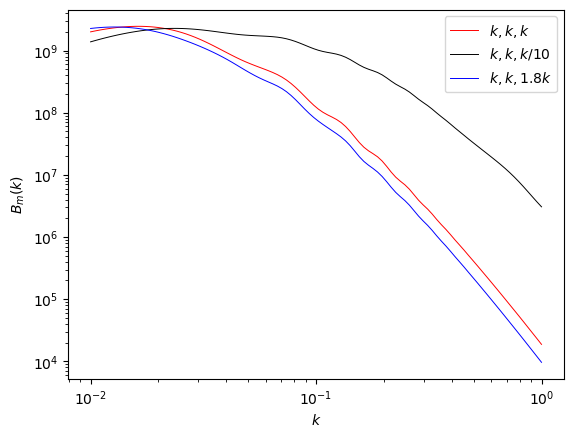

In [233]:
plt.loglog()
plt.plot(krange, (0.67)**3*ANS,  c = 'red', label = r'$k,k,k$', lw = 0.7 )
plt.plot(krange, (0.67)**3*ANS2, c = 'black', label = r'$k,k,k/10$', lw = 0.7)
plt.plot(krange, (0.67)**3*ANS3, c = 'blue', label = r'$k,k,1.8k$', lw = 0.7)
plt.xlabel(r'$k$')
plt.ylabel(r'$B_m(k)$')
plt.legend()
plt.show()

In [162]:

def CLx(l):
    c = 3e5  # Speed of light in km/s
    omega_m = 0.311
    H0 = 67.66  # Hubble constant in km/s/Mpc
    Normalization = (3 / 2) * omega_m * (H0 / c)**2

    # Define the kernel for integration
    def kernel(z):
        # Comoving distance and Hubble rate
        Dc_z = background_lcdm.Comoving_distance(z, method="BA")
        Dc_max = background_lcdm.Comoving_distance(1090, method="BA")
        H_z = background_lcdm.Hubble_rate(z, method="BA")
        
        # Avoid division by zero for Dc_z and H_z
        if Dc_z == 0 or H_z == 0:
            return 0

        # Terms of the kernel
        term1 = (1 - Dc_z / Dc_max)**3
        term2 = (1 / Dc_z) * (1 + z)**3 / H_z
        k = l / Dc_z
        term3 = PerturbationTheory(eos_lcdm, background_lcdm).bispectrum_z(k, k, k, z, method="BA")

        return term1 * term2 * term3

    # Perform the integration over redshift z
    PkappaL, _ = quad(kernel, 0.1, 1090, limit=100)
    PkappaL *= Normalization**3 * c  # Apply normalization

    return PkappaL


In [157]:
l_values = 10**np.linspace(1, 3, 20)
Cl3 = []
for l in l_values:
    Cl3 += [CLx(l)]


In [172]:
l_values

array([  10.        ,   12.74274986,   16.23776739,   20.69138081,
         26.36650899,   33.59818286,   42.81332399,   54.55594781,
         69.51927962,   88.58667904,  112.88378917,  143.84498883,
        183.29807108,  233.57214691,  297.63514416,  379.26901907,
        483.29302386,  615.84821107,  784.75997035, 1000.        ])

In [164]:
Cl = []
for l in l_values:
    Cl += [CLx(l)]


In [166]:
#l_values = 10**np.linspace(1, 3, 20)
Cl3 = np.array(Cl3)
Cl = np.array(Cl)

In [168]:
Cl

array([1.32922388e-13, 1.44708239e-13, 1.48361910e-13, 1.44670844e-13,
       1.35717838e-13, 1.22754753e-13, 1.06186273e-13, 8.77851686e-14,
       6.92337968e-14, 5.18552087e-14, 3.68028293e-14, 2.47451826e-14,
       1.58020663e-14, 9.61904090e-15, 5.58329981e-15, 3.06964398e-15,
       1.58281938e-15, 7.64914909e-16, 3.51144357e-16, 1.54228855e-16])

In [187]:
Cl3

array([9.90754159e-14, 1.18846191e-13, 1.34914468e-13, 1.45109881e-13,
       1.48559462e-13, 1.45162193e-13, 1.35544167e-13, 1.21738886e-13,
       1.05204792e-13, 8.69394631e-14, 6.86444740e-14, 5.16507796e-14,
       3.69368158e-14, 2.50666371e-14, 1.61387389e-14, 9.86729886e-15,
       5.73943074e-15, 3.17899271e-15, 1.67117274e-15, 8.27469166e-16])

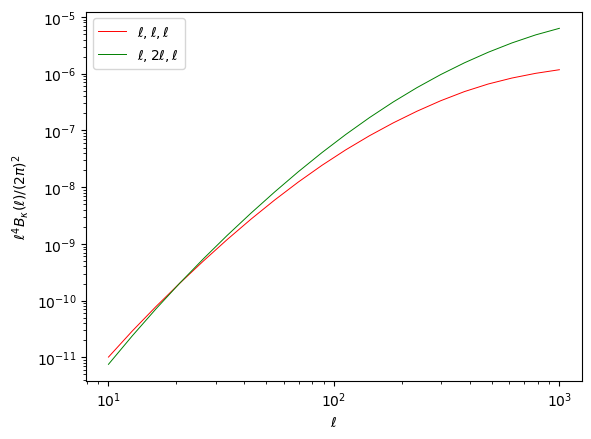

In [229]:
plt.loglog()
plt.plot(l_values, l_values**4 * Cl * 0.67**3/ (4*np.pi**2),c = 'red', label=r'$\ell,\ell,\ell$', lw = 0.7)
#plt.plot(l_values, l_values**4 * Cl2 * 0.67**3/ (4*np.pi**2), label='ll/2l/2')
plt.plot(l_values, l_values**4 * Cl3 * 0.67**3/ (4*np.pi**2), c = 'green', label=r'$\ell,2\ell,2\ell$', lw = 0.7)
plt.ylabel(r'$\ell^4 B_{\kappa} (\ell)/(2 \pi)^2$')
plt.xlabel(r'$\ell$')
plt.legend()